In [1]:
# %pip install lime

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# sklearn Regressor Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# import Visualisation library
from tabulate import tabulate

import ta
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(
    'ignore', 'invalid value encountered in double_scalars')


# Discussion 1: Determine the best period (time) for model training.

In [3]:
# Set different start dates
start_dates = ['2012-03-01', '2013-03-01', '2014-03-01',
               '2015-03-01', '2016-03-01', '2017-03-01',
               '2018-03-01', '2019-03-01', '2020-03-01', '2021-03-01']

# Set end date for historical price data
end_date = '2023-03-01'

# Set empty lists to store evaluation metrics
r2_svr_train_list = []
r2_svr_test_list = []
mse_svr_train_list = []
mse_svr_test_list = []
mae_svr_train_list = []
mae_svr_test_list = []

r2_rfr_train_list = []
r2_rfr_test_list = []
mse_rfr_train_list = []
mse_rfr_test_list = []
mae_rfr_train_list = []
mae_rfr_test_list = []

for i, start_date in enumerate(start_dates):
    # Download historical price data from Yahoo Finance and store in a pandas DataFrame for each start date
    df = yf.download("GOOGL", start=start_date,
                     end=end_date, progress=False)

    # Create a new column for the dependent variable
    df['PriceAfterMonth'] = df['Close'].shift(-20)

    # Remove rows with missing values
    df.dropna(inplace=True)

    # Define the independent and dependent variables
    X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    y = df['PriceAfterMonth']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=30, shuffle=False)

    # Preprocess the data by scaling it
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build SVR model
    svr_model = SVR(kernel='linear', C=10, gamma='auto')
    # Fit the SVR model with a constant term
    X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
    X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

    svr_model.fit(X_train_with_const, y_train)

    # # Build RFR model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
    rfr_model.fit(X_train, y_train)

    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train_with_const)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test_with_const)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)
    
    r2_svr_train_list.append(r2_svr_train)
    mse_svr_train_list.append(mse_svr_train)
    mae_svr_train_list.append(mae_svr_train)

    r2_svr_test_list.append(r2_svr_test)
    mse_svr_test_list.append(mse_svr_test)
    mae_svr_test_list.append(mae_svr_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)
    
    r2_rfr_train_list.append(r2_rfr_train)
    mse_rfr_train_list.append(mse_rfr_train)
    mae_rfr_train_list.append(mae_rfr_train)
    r2_rfr_test_list.append(r2_rfr_test)
    mse_rfr_test_list.append(mse_rfr_test)
    mae_rfr_test_list.append(mae_rfr_test)

svr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    svr_row = [year, r2_svr_train_list[i], r2_svr_test_list[i], mse_svr_train_list[i],
            mse_svr_test_list[i], mae_svr_train_list[i], mae_svr_test_list[i]]
    svr_table.append(svr_row)

print("SVR Model")
print(tabulate(svr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

rfr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    rfr_row = [year, r2_rfr_train_list[i], r2_rfr_test_list[i], mse_rfr_train_list[i],
            mse_rfr_test_list[i], mae_rfr_train_list[i], mae_rfr_test_list[i]]
    rfr_table.append(rfr_row)

print("RFR Model")
print(tabulate(rfr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


SVR Model
╒════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│   Year │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│   2012 │     0.96974  │   0.761045  │        9.9096 │      83.1076 │       2.03668 │      7.16519 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2013 │     0.962801 │   0.715288  │       12.4786 │      92.4188 │       2.28266 │      7.45306 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2014 │     0.962696 │   0.698897  │       14.7285 │     103.957  │       2.53701 │      7.85802 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2015 │     0.965628 │   0.692666  │       16.6443 │     118.246  │  

Ans: SVR model is good with data starting from 2012, while RFR model is good with data starting from 2015. Overall, I will continue with Year 2015, since both model can perform prediction.

# Discussion 2: Determine how well can SVR & RFR model predict future stock price.

In [4]:
def evaluate_train_test(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    result_table = []

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table.append(svr_result)
    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


In [5]:
def evaluate_train_test_svr(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    result_table = []

    result_table.append(svr_result)
    
    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


In [6]:
def evaluate_train_test_rfr(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table = []

    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


## Base Model

In [7]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [8]:
evaluate_train_test(X_train, X_test)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965628 │    0.692667 │      16.6443  │      118.246 │      2.75005  │      8.61792 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995668 │    0.701868 │       2.09756 │      114.706 │      0.979002 │      9.13135 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.543634 │       12.5206  │        2.81349 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.790053 │        5.75999 │        1.90385 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


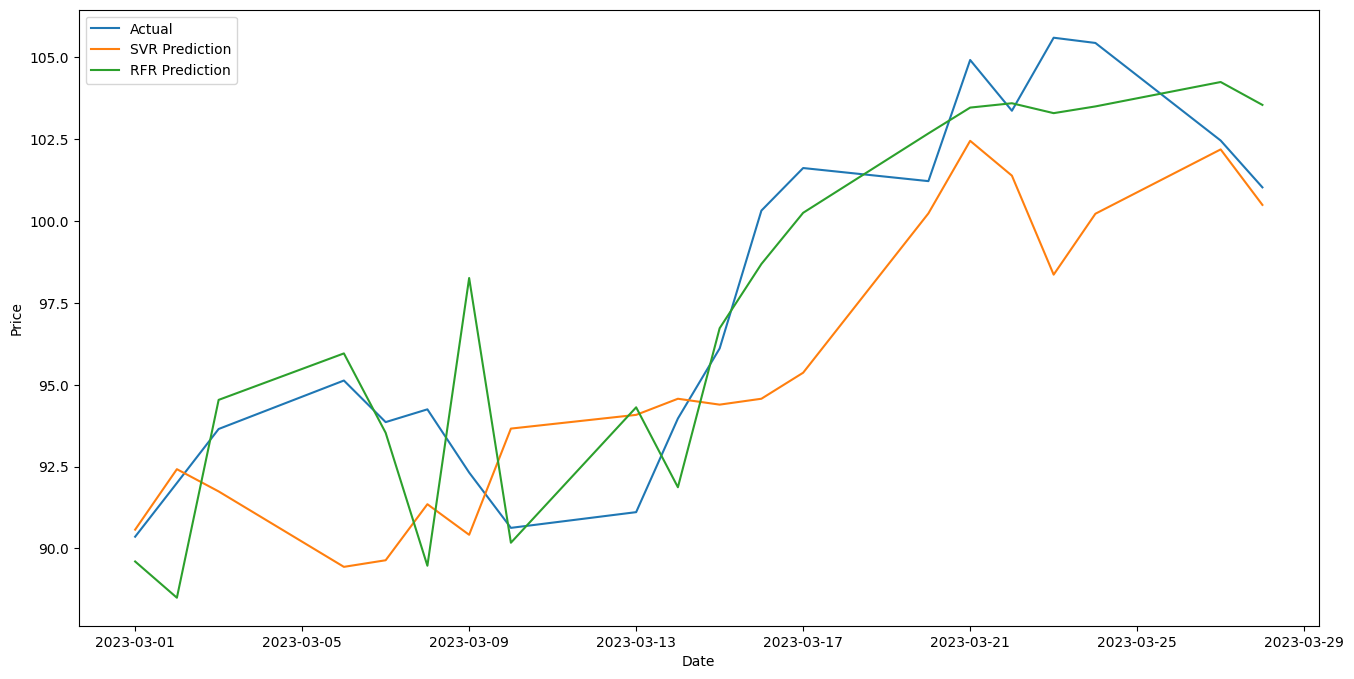

In [9]:
# Download latest 30 days historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred)
y_rfr_pred = rfr_model.predict(X_pred)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Add Feature Selection using correlation coefficient


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │      16.6461  │      118.915 │       2.75058 │      8.64266 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995447 │    0.710577 │       2.20486 │      111.355 │       1.00013 │      8.97004 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.548809 │       12.3787  │        2.79208 │
├─────────┼───────────────┼────

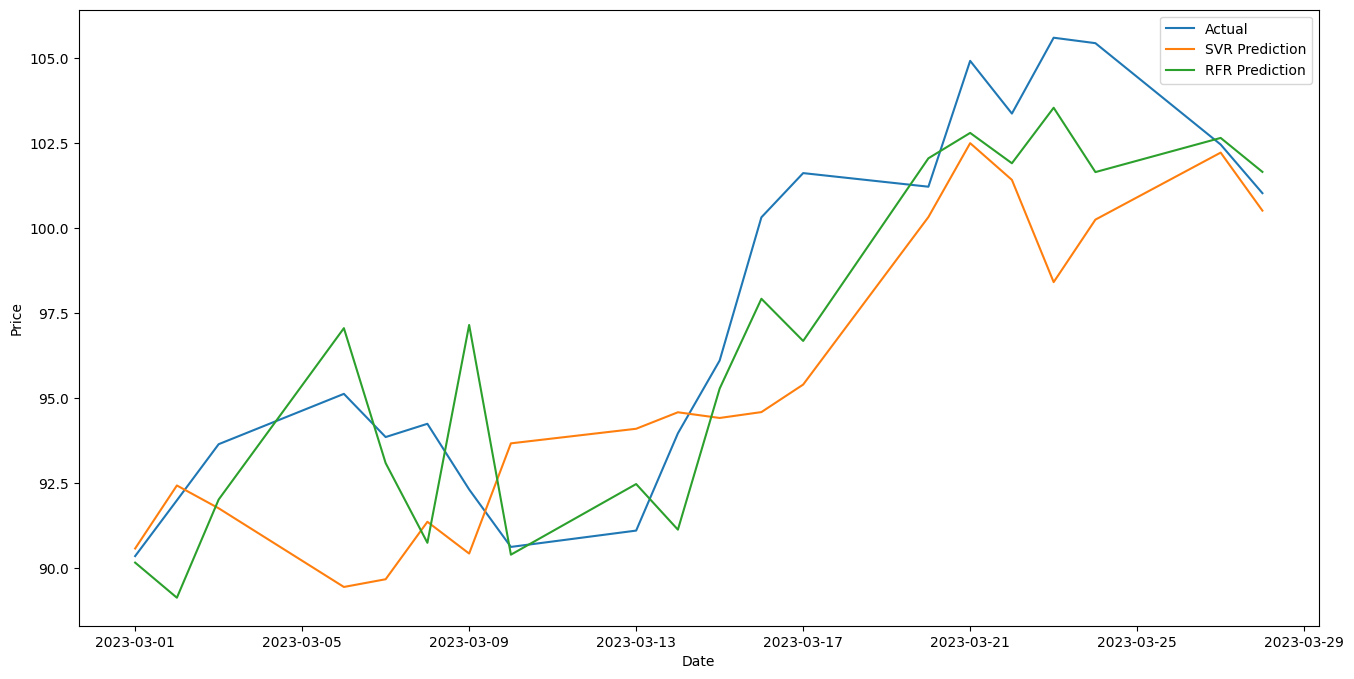

In [10]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train, y_train)

evaluate_train_test(X_train, X_test)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred)
y_rfr_pred = rfr_model.predict(X_pred)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


It makes RFR model slightly bad, but the SVR is slightly better. 

## Add PCA

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │       16.6461 │      118.915 │      2.75058  │      8.64265 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995542 │    0.686172 │        2.1588 │      120.745 │      0.990165 │      9.31317 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.548808 │        12.3787 │        2.79209 │
├─────────┼───────────────┼────

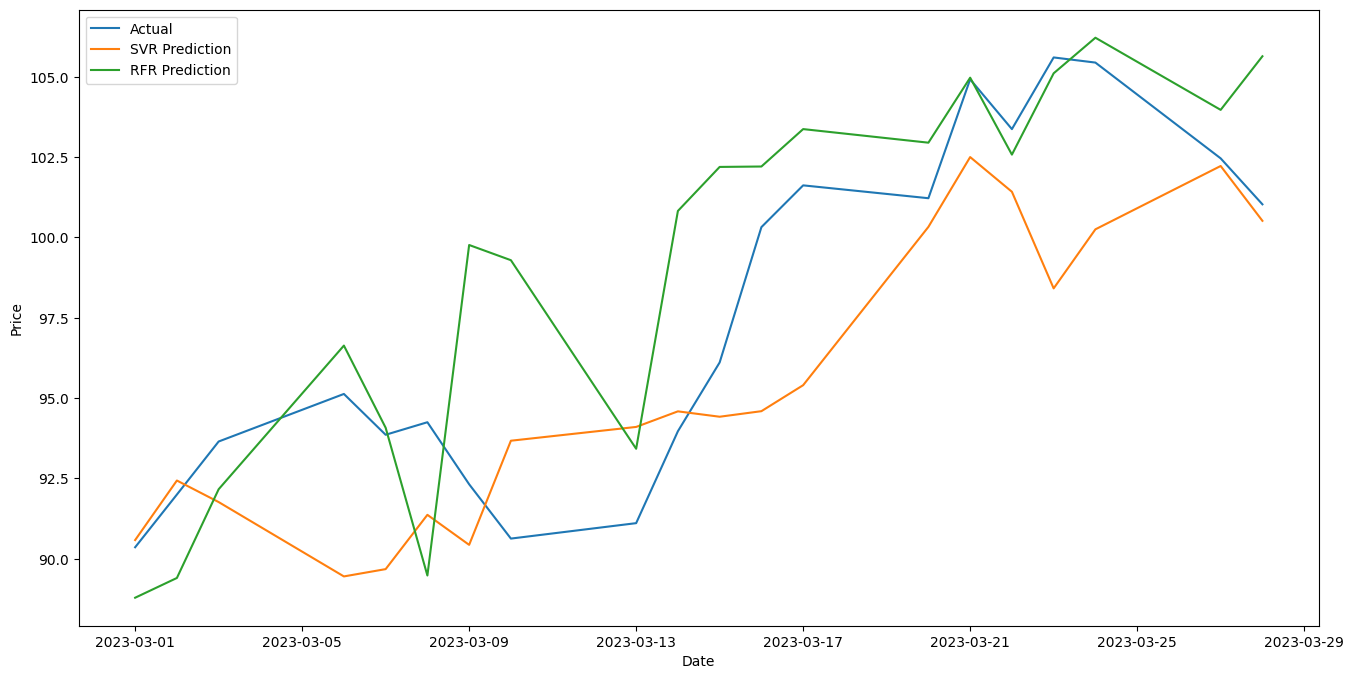

In [14]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the PCA model:
pca_model = PCA(n_components=5)

# Fit the PCA model to the training data:
pca_model.fit(X_train)
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_pca, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_pca, y_train)

evaluate_train_test(X_train_pca, X_test_pca)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_pca = pca_model.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_pca)
y_rfr_pred = rfr_model.predict(X_pred_pca)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


After using PCA, it makes RFR & SVR model become worse.

## Add PolynomialFeatures without Constant (bias)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965858 │    0.701865 │      16.5329  │      114.707 │       2.74634 │      8.52332 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995361 │    0.718035 │       2.24649 │      108.486 │       1.00192 │      8.86606 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.601316 │       10.9381  │        2.61774 │
├─────────┼───────────────┼────

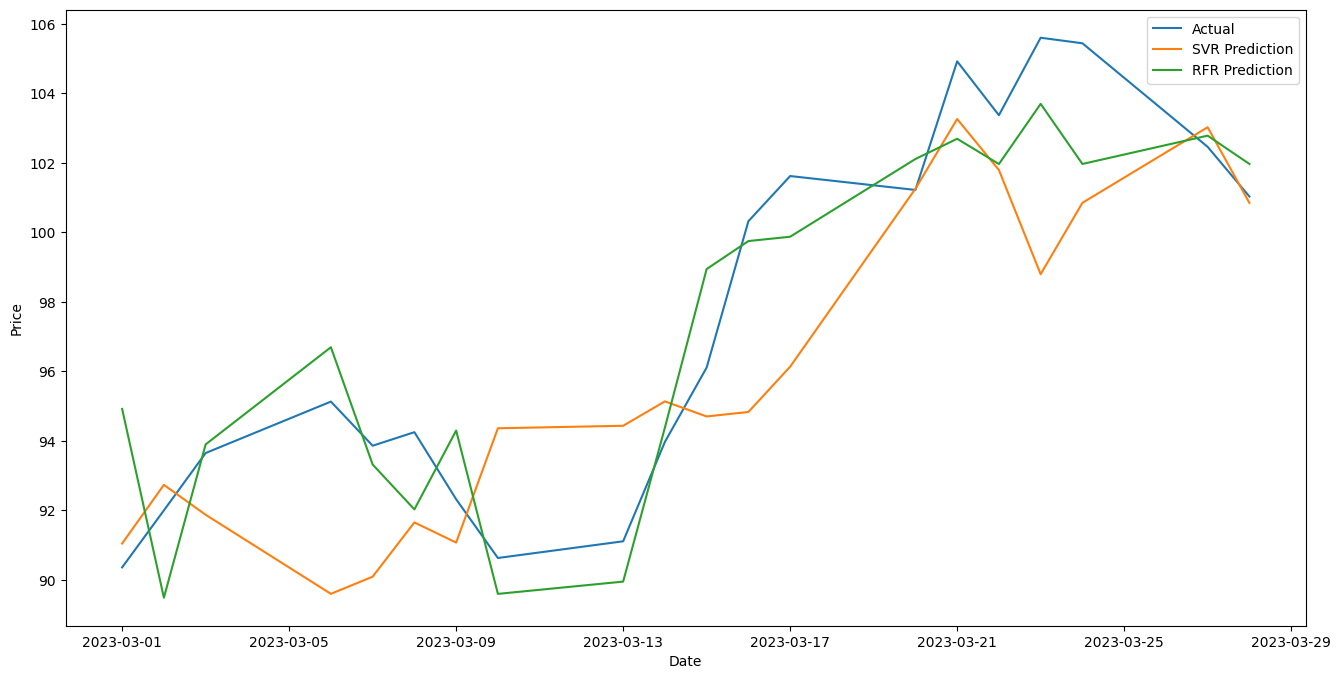

In [15]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_poly, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(
    n_estimators=50, random_state=10)
rfr_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)
y_rfr_pred = rfr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Add PolynomialFeatures with Constant (bias)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965858 │    0.701862 │      16.5329  │      114.708 │      2.74634  │      8.52336 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995341 │    0.719485 │       2.25623 │      107.928 │      0.999347 │      8.82471 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.601322 │       10.9379  │        2.61772 │
├─────────┼───────────────┼────

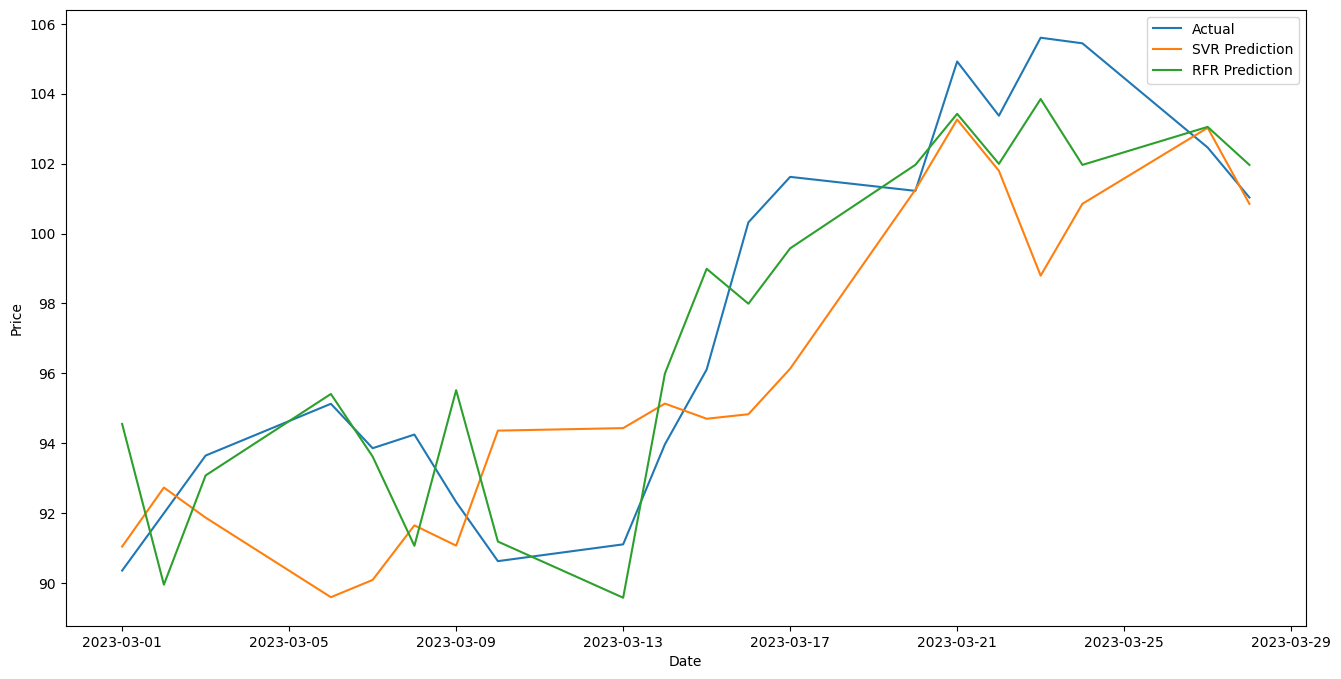

In [16]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_poly, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(
    n_estimators=50, random_state=10)
rfr_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)
y_rfr_pred = rfr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


RFR models has been doing well right now. However, SVR still need to perform extra techinque.

## Add Features by using Technical Indicators 


In [17]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10)
svr_model.fit(X_train_poly, y_train)

evaluate_train_test_svr(X_train_poly, X_test_poly)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.966287 │    0.681362 │       16.7373 │      123.339 │       2.77767 │      8.87546 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.646776 │        9.69089 │        2.55584 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.839104 │        4.41427 │        1.77201 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


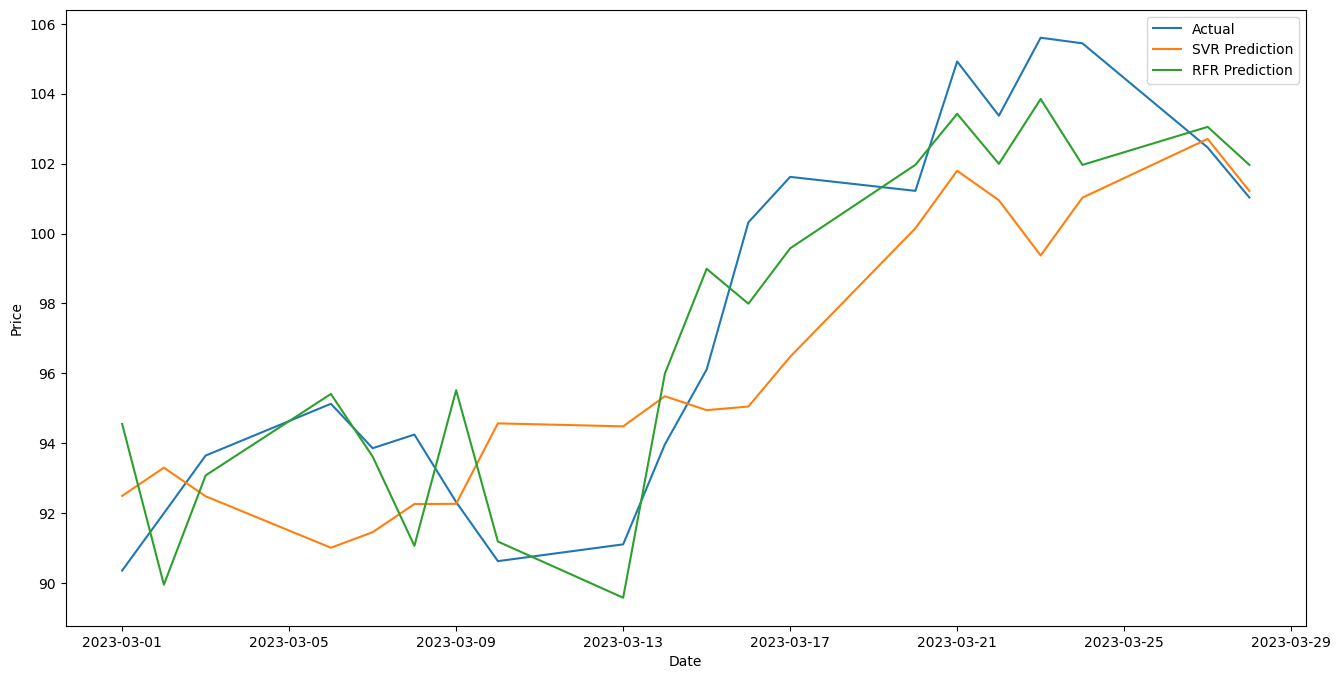

In [18]:
# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Apply GridSearchCV

RFR Model

In [19]:
result_table = []

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=10),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_poly, y_train)

# Get the best model
rfr_model = grid_search_rfr.best_estimator_

# Calculate evaluation metrics for RFR model
y_rfr_pred_train = rfr_model.predict(X_train_poly)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

y_rfr_pred_test = rfr_model.predict(X_test_poly)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
            mse_rfr_test, mae_rfr_train, mae_rfr_test]
result_table.append(rfr_result)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_rfr_pred = rfr_model.predict(X_pred_poly)

SVR model

In [20]:
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 10, 100, 1000],
    'gamma': ['auto', 'scale'],
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train_poly, y_train)

# Get the best model
svr_model = grid_search_svr.best_estimator_

# Calculate evaluation metrics for SVR model
y_svr_pred_train = svr_model.predict(X_train_poly)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

y_svr_pred_test = svr_model.predict(X_test_poly)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
            mse_svr_test, mae_svr_train, mae_svr_test]

result_table.append(svr_result)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

Evaluate SVR & RFR Performance Based on Actual Data

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.702436 │        8.16381 │        2.35607 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.868171 │        3.6168  │        1.67461 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


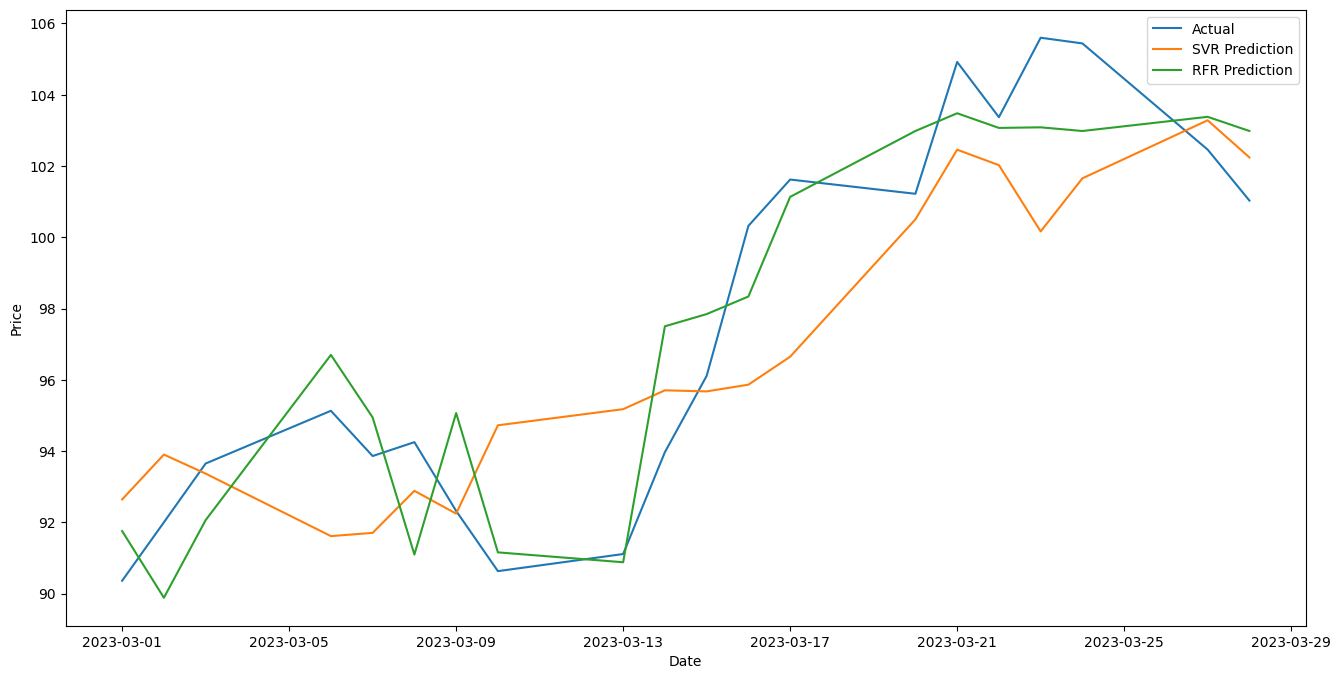

In [21]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Ensemble Model (RFR + SVR)

In [22]:
from sklearn.ensemble import VotingRegressor

# Use VotingRegressor to combine RFR and SVR models
ensemble_model = VotingRegressor(estimators=[('rfr', rfr_model), ('svr', svr_model)])
ensemble_model.fit(X_train_poly, y_train)

y_ensemble_pred_train = ensemble_model.predict(X_train_poly)
r2_ensemble_train = r2_score(y_train, y_ensemble_pred_train)
mse_ensemble_train = mean_squared_error(y_train, y_ensemble_pred_train)
mae_ensemble_train = mean_absolute_error(y_train, y_ensemble_pred_train)

y_ensemble_pred_test = ensemble_model.predict(X_test_poly)
r2_ensemble_test = r2_score(y_test, y_ensemble_pred_test)
mse_ensemble_test = mean_squared_error(y_test, y_ensemble_pred_test)
mae_ensemble_test = mean_absolute_error(y_test, y_ensemble_pred_test)

ensemble_result = ["Ensemble", r2_ensemble_train, r2_ensemble_test, mse_ensemble_train,
            mse_ensemble_test, mae_ensemble_train, mae_ensemble_test]

result_table.append(ensemble_result)

y_ensemble_pred = ensemble_model.predict(X_pred_poly)

In [23]:
# Calculate evaluation metrics for train & test set from each model
print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                    "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

╒══════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model    │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞══════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ RFR      │     0.985941 │    0.694276 │       6.80819 │     117.627  │       1.7612  │      9.34163 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ SVR      │     0.96614  │    0.714032 │      16.8104  │     110.692  │       2.82358 │      8.30972 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ Ensemble │     0.980655 │    0.742915 │       9.60384 │      99.5126 │       2.09581 │      7.99118 │
╘══════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒══════════╤═══════════════╤════════════════╤════════════════╕
│ Model    │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞══════════╪═══════════════╪════════════════╪════════════════╡
│ SVR      │      0.702436 │        8.16381 │        2.35607 │
├──────────┼───────────────┼────────────────┼────────────────┤
│ RFR      │      0.868171 │        3.6168  │        1.67461 │
├──────────┼───────────────┼────────────────┼────────────────┤
│ Ensemble │      0.82198  │        4.88408 │        1.86393 │
╘══════════╧═══════════════╧════════════════╧════════════════╛


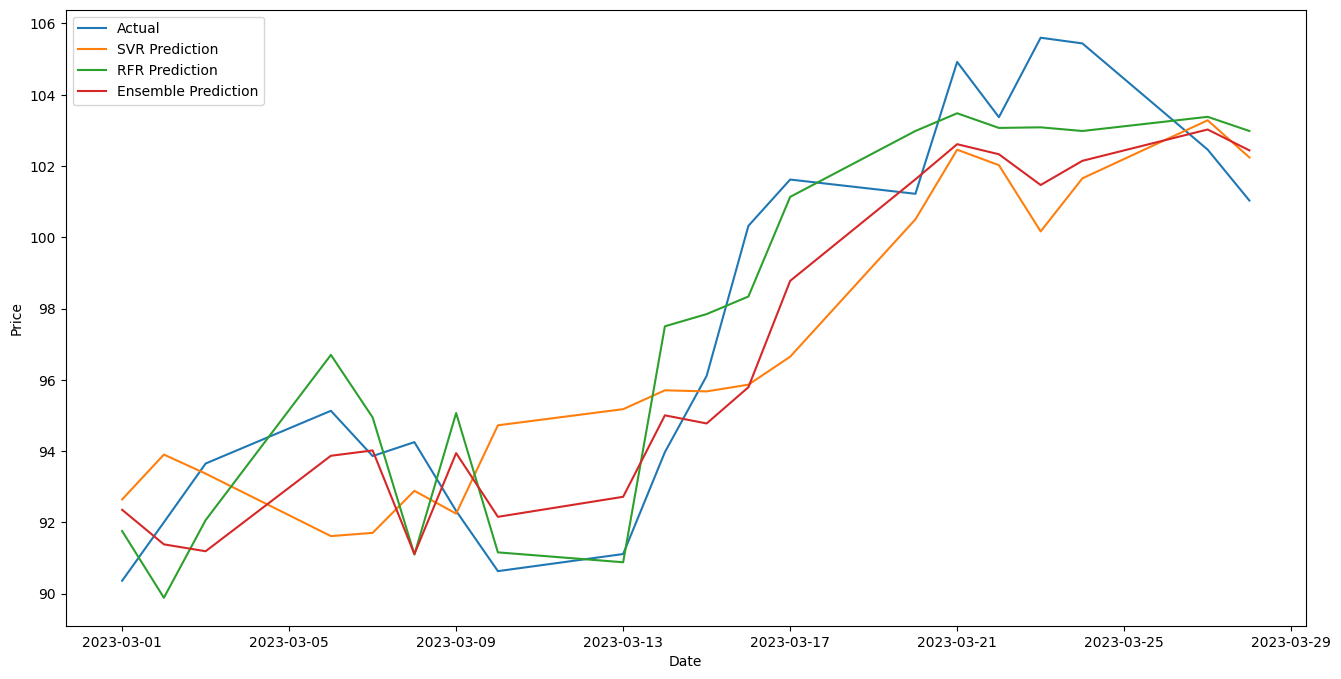

In [24]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred,
                        'Ensemble Predcition': y_ensemble_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for ensemble model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Calculate evaluation metrics for RFR model
r2_ensemble_actual = r2_score(
    df_combined['Close'], df_combined['Ensemble Predcition'])
mse_ensemble_actual = mean_squared_error(
    df_combined['Close'], df_combined['Ensemble Predcition'])
mae_ensemble_actual = mean_absolute_error(
    df_combined['Close'], df_combined['Ensemble Predcition'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual],
         ["Ensemble", r2_ensemble_actual, mse_ensemble_actual, mae_ensemble_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.plot(df_combined.index,
         df_combined['Ensemble Predcition'], label='Ensemble Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Interepret Library

## SHAP

Permutation explainer: 394it [12:22,  1.91s/it]                         


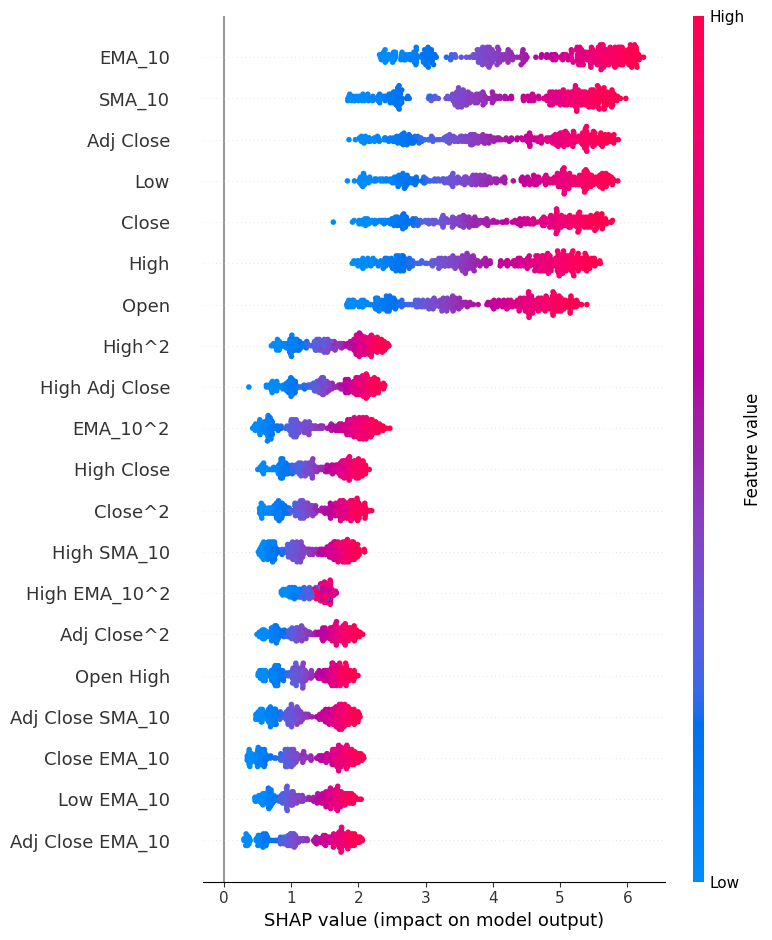

In [26]:
import shap

feature_names = poly.get_feature_names_out(X.columns)

def ensemble_predict(X):
    preds = ensemble_model.predict(X)
    return preds

explainer = shap.Explainer(ensemble_predict, X_train_poly)
shap_values = explainer(X_test_poly)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_poly, feature_names=feature_names)

## Lime

[('Close^2 Adj Close', 5.756329700695349e-05), ('Adj Close^3', 5.73954074984164e-05), ('Open Close Adj Close', 5.6968316251206755e-05), ('Adj Close^2 EMA_10', 5.694980276361744e-05), ('Low Close^2', 5.6932701275095905e-05), ('Low Adj Close^2', 5.686739970030306e-05), ('Low Close EMA_10', 5.6844548562633936e-05), ('Close Adj Close^2', 5.678292527785399e-05), ('Adj Close^2 SMA_10', 5.677975305929162e-05), ('Low Close Adj Close', 5.6659450907234044e-05), ('Close^2 EMA_10', 5.6640100678524626e-05), ('Close^3', 5.6625763013476336e-05), ('Low Adj Close EMA_10', 5.660457294968669e-05), ('High Close^2', 5.6595674587611936e-05), ('Open Adj Close^2', 5.656208584950089e-05), ('Low^2 Close', 5.65524013967824e-05), ('Low^3', 5.654407715675815e-05), ('Low^2 Adj Close', 5.65042193491373e-05), ('Open Close^2', 5.647239064329114e-05), ('Close Adj Close EMA_10', 5.644973582531292e-05)]


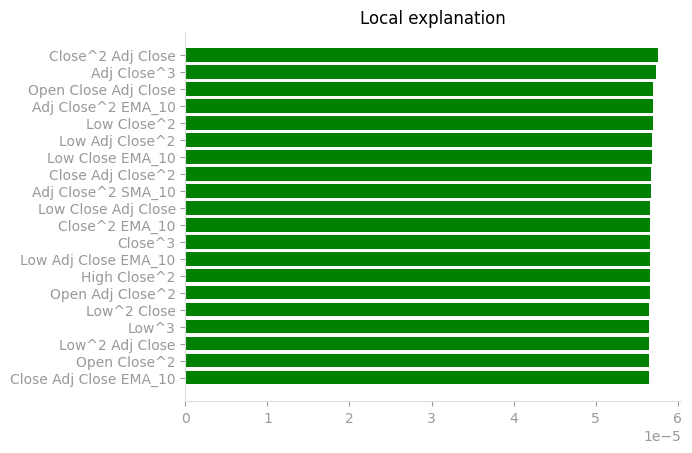

In [40]:
import lime.lime_tabular

# assuming 'ensemble_model' is your trained regression ensemble model
def predict(X):
    preds = ensemble_model.predict(X)
    return preds


explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_poly,
                                                   mode='regression',
                                                   feature_names=feature_names,
                                                   class_names=None,
                                                   discretize_continuous=False)

# explain a single instance using the LIME explainer
exp = explainer.explain_instance(
    X_test_poly[1], predict, num_features=20)

# print the LIME explanation
print(exp.as_list())

# plot the LIME explanation
exp.show_in_notebook()

# style the LIME explanation using to_pyplot()
fig = exp.as_pyplot_figure()
axes = fig.get_axes()[0]  # get the axes object

# adjust the spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.spines['left'].set_color('#DDDDDD')
axes.tick_params(axis='x', colors='#999999')
axes.tick_params(axis='y', colors='#999999')
axes.yaxis.label.set_color('#999999')
axes.xaxis.label.set_color('#999999')

# # plot the feature importance bar chart
# fig, ax = plt.subplots()
# feature_importance = exp.as_list()
# labels, values = zip(*feature_importance)
# ax.barh(labels, values)
# ax.set_xlabel('Importance')
# ax.set_title('LIME Feature Importance')
# plt.show()
